# Cleaning, pre-processing, exploring and clustering (segmenting) a dataset containing information about customers.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import umap as up

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import LabelEncoder, RobustScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import LocalOutlierFactor
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from seaborn import pairplot, heatmap

In [2]:
data = pd.read_csv("train.csv")
data_test = pd.read_csv("test.csv")
data.shape[0]

8068

### The data provided contains both train and test set, but as we will not be doing regression or classification we will combine these two datasets.

In [3]:
data = pd.concat([data, data_test], axis=0)
data.shape[0]

10695

In [4]:
data.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


### Lets drop the first and last column as they are no use for us.

In [5]:
data.drop(["ID", "Segmentation"], axis=1, inplace=True)

## Encode Categorical Data

### Encode categorical data before cleaning as we will utilize iterative imputer for missing values, which requires that all columns contain numeric values only.

In [6]:
# Categories with no ordering and are binary, where the assignment of 0 or 1 matters because of interpretability
cat_no_order = ["Gender", "Ever_Married", "Graduated"]
for col in cat_no_order:
    if col == "Gender":
        data[col] = data[col].map({"Female" : 0, "Male" : 1})
    else:
        data[col] = data[col].map({"No" : 0, "Yes" : 1})

In [7]:
# Unique values in categorical columns which have ordering
cat_order = ["Spending_Score", "Var_1"]
for col in cat_order:
    print(data[col].unique())

# Use pandas mapping to map these values ordinally. Normally use OrdinalEncoder but just use mapping as there aren't too many categories.
data[cat_order[0]] = data[cat_order[0]].map({"Low" : 0, "Average" : 1, "High" : 2})
data[cat_order[1]] = data[cat_order[1]].map({"Cat_1" : 0, "Cat_2" : 1, "Cat_3" : 2, "Cat_4" : 3, "Cat_5" : 4, "Cat_6" : 5, "Cat_7" : 6})

['Low' 'Average' 'High']
['Cat_4' 'Cat_6' 'Cat_7' 'Cat_3' 'Cat_1' 'Cat_2' nan 'Cat_5']


In [8]:
# Categories with no ordering but multiple classes
le = LabelEncoder()
data["Profession"] = le.fit_transform(data["Profession"])

In [9]:
data.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
0,1,0.0,22,0.0,5,1.0,0,4.0,3.0
1,0,1.0,38,1.0,2,NaN,1,3.0,3.0
2,0,1.0,67,1.0,2,1.0,0,1.0,5.0
3,1,1.0,67,1.0,7,0.0,2,2.0,5.0
4,0,1.0,40,1.0,3,NaN,2,6.0,5.0


## Cleaning

In [10]:
def get_missing():
    return data.isnull().mean() * 100

In [11]:
data_null_mean = get_missing()
data_null_mean.round(2)

Gender              0.00
Ever_Married        1.78
Age                 0.00
Graduated           0.95
Profession          0.00
Work_Experience    10.27
Spending_Score      0.00
Family_Size         4.19
Var_1               1.01
dtype: float64

<AxesSubplot:>

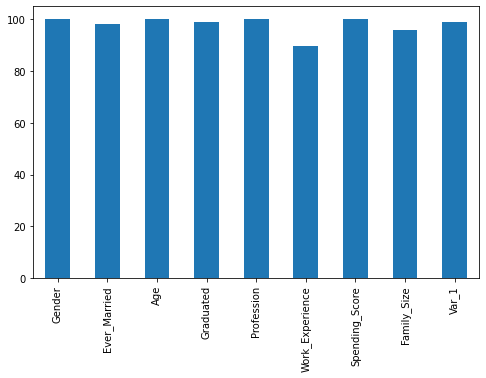

In [12]:
fig, ax = plt.subplots(figsize=(8, 5))
(100 - data_null_mean).abs().plot.bar(ax=ax)

### As there is no extreme amount of missing values, let us impute all the columns using the sophisticated IterativeImputer.

In [13]:
def get_missing_cols(): # Separate columns with missing values into numeric and categorical lists.
    missing_num = []
    missing_cat = []
    for col in list(data.isnull().columns):
        if data[col].dtypes == "object":
            missing_cat.append(col)
        else:
            missing_num.append(col)
    return (missing_num, missing_cat)

In [14]:
num, cat = get_missing_cols()
missing_cols = (num + cat)
imputer = IterativeImputer(RandomForestRegressor(n_jobs=-1), tol=0.1)
data[missing_cols] = imputer.fit_transform(data[missing_cols])

In [15]:
get_missing()

Gender             0.0
Ever_Married       0.0
Age                0.0
Graduated          0.0
Profession         0.0
Work_Experience    0.0
Spending_Score     0.0
Family_Size        0.0
Var_1              0.0
dtype: float64

### Cleaning column names. The columns headers are not "python friendly" and I can spot at least one that isn't very descriptive. Lets change that.

In [16]:
def clean_col_name(name):
    return name.strip().lower().replace(" ", "_")

In [17]:
data.rename(columns={"Var_1" : "customer_category"}, inplace=True) # Rename Var_1 to "(anomymous) customer category"
data.rename(columns=clean_col_name, inplace=True)
data.head()

,gender,ever_married,age,graduated,profession,work_experience,spending_score,family_size,customer_category
0,1.0,0.0,22.0,0.0,5.0,1.000000,0.0,4.0,3.0
1,0.0,1.0,38.0,1.0,2.0,5.890000,1.0,3.0,3.0
2,0.0,1.0,67.0,1.0,2.0,1.000000,0.0,1.0,5.0
3,1.0,1.0,67.0,1.0,7.0,0.000000,2.0,2.0,5.0
4,0.0,1.0,40.0,1.0,3.0,5.783333,2.0,6.0,5.0


### Save a copy of the original, cleaned data.

In [18]:
data_original = data.copy()

## Exploratory Data Analysis

### Pairplot (scatter and distribution) the numerical data.

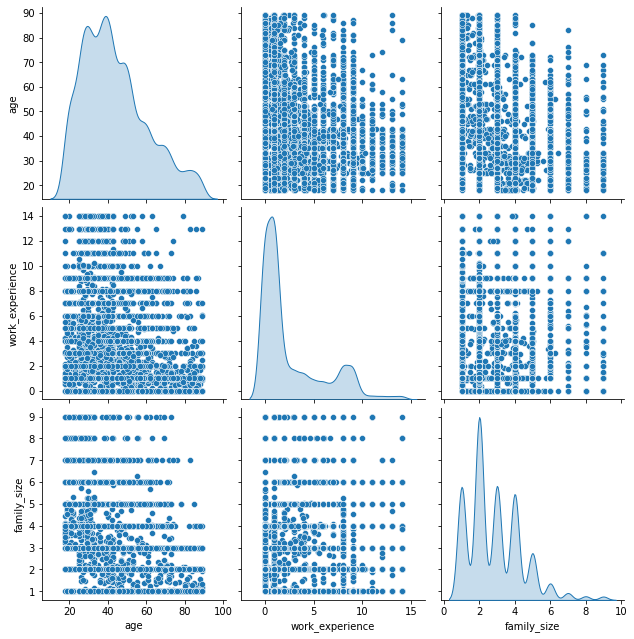

In [19]:
pairplot(
    data=data, 
    vars=["age", "work_experience", "family_size"], 
    kind="scatter",
    diag_kind="kde",
    height=3
)

### Some quick observations:
### Most of the ages are distributed around age 30-60. 
### Most of the work experience is around 0-5.
### Most common family size is 2.
### Not surprising, but people of greater age have more work experience.
### Sadly family size seems to get smaller with age.

### Pairplot (scatter and distribution) the categorical data.

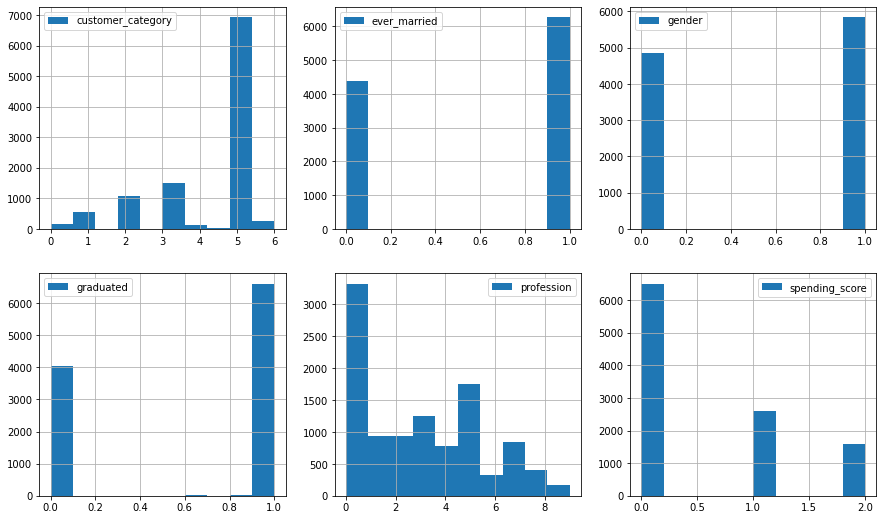

In [20]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 9))
r_idx = 0
c_idx = 0
for col in data.columns.difference(["age", "work_experience", "family_size"]):
    data[col].hist(ax=axes[r_idx][c_idx], legend=True)
    c_idx += 1
    if c_idx > 2:
        r_idx += 1
        c_idx = 0

### Some quick observations:
### Most customers are in (anonymized) category of 5.
### Most customers spend a "low" (0) amount.
### Most customers' profession is, interestingly, artist (0).
### Most people have graduated (dataset didn't specify graduate where, but I'm assuming college).

### Correlation Matrix

<AxesSubplot:>

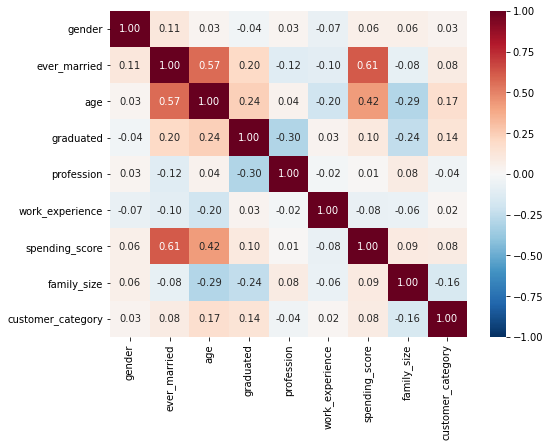

In [21]:
fig, ax = plt.subplots(figsize=(8, 6))
heatmap(
    data.corr(),
    fmt=".2f",
    annot=True,
    ax=ax,
    cmap="RdBu_r",
    vmin=-1,
    vmax=1,
)

### There are no very significant correlations.
### Most significant observations are:
### People of greater age have greater spending score, or in other words, they spend more. Perhaps because their salaries are better.
### People who are married also have greater spending score.

## We will now use Dimensionality Reduction to visualize all of our data in 2D. But first, we will need to check for significant outliers as the method we will be using, PCA, is very susceptible to outliers.

### Lets use Local Outlier Factor algorithm for detecting possible outliers.

<AxesSubplot:ylabel='Density'>

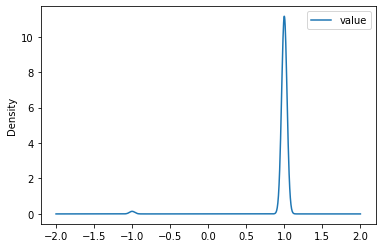

In [22]:
lof = LocalOutlierFactor()
out_pred = pd.DataFrame({"value" : lof.fit_predict(data)})
out_pred.plot.kde()

### There seems to be some outliers (-1). We could remove these outliers, but lets use RobustScaler instead to standardize data in a way that is not very susceptible to outliers.

In [23]:
rs = RobustScaler()
data = pd.DataFrame(data=rs.fit_transform(data), columns=data.columns)
data.head()

,gender,ever_married,age,graduated,profession,work_experience,spending_score,family_size,customer_category
0,0.0,-1.0,-0.826087,-1.0,0.4,0.000000,0.0,0.625,-1.0
1,-1.0,0.0,-0.130435,0.0,-0.2,1.222500,1.0,0.125,-1.0
2,-1.0,0.0,1.130435,0.0,-0.2,0.000000,0.0,-0.875,0.0
3,0.0,0.0,1.130435,0.0,0.8,-0.250000,2.0,-0.375,0.0
4,-1.0,0.0,-0.043478,0.0,0.0,1.195833,2.0,1.625,0.0


### Now that our data is robustly standardized lets use PCA to reduce dimensions to 3 for visualization.

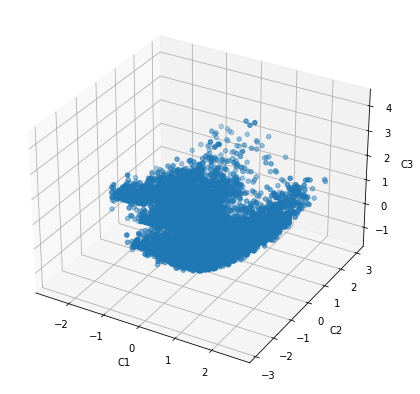

In [24]:
pca = PCA(n_components=3)
data_pca = pd.DataFrame(data=pca.fit_transform(data), columns=["C1", "C2", "C3"])

fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(projection='3d')
ax.scatter(data_pca.iloc[:,0], data_pca.iloc[:,1], data_pca.iloc[:,2])
ax.set_xlabel("C1")
ax.set_ylabel("C2")
_ = ax.set_zlabel("C3")

### Lets see how much of the variance of our data set our dimensionality reduced data explains.

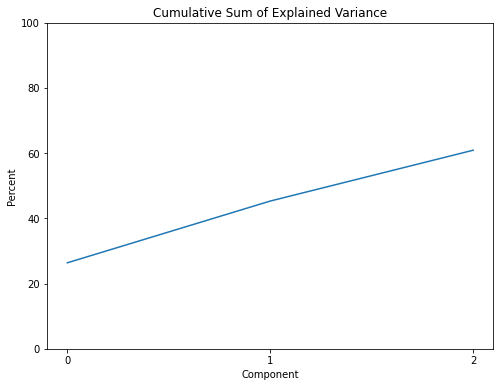

In [25]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xticks(np.arange(len(pca.explained_variance_ratio_), step=1))
ax.plot(np.cumsum(pca.explained_variance_ratio_ * 100))
_ = ax.set(
    xlabel="Component",
    ylabel="Percent",
    title="Cumulative Sum of Explained Variance",
    ylim=(0, 100),
)

### Lets also see how much each feature contributes to each component.

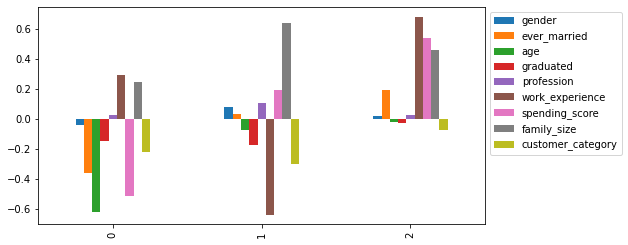

In [26]:
fig, ax = plt.subplots(figsize=(8, 4))
pd.DataFrame(
    pca.components_, columns=data.columns
).plot(kind="bar", ax=ax).legend(
    bbox_to_anchor=(1, 1)
)

### Lets also try UMAP dimensionality reduction. UMAP is a newer dimensionality reduction algorithm which is great for both visualization and general purpose dimensionality reduction.

In [27]:
def draw_umap(n_neighbors=20, min_dist=0.1, n_components=3, metric="euclidean"): # Quick helper function to test different UMAP parameters
    umap = up.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric
    )
    data_umap_np = umap.fit_transform(data)
    data_umap = pd.DataFrame(data=data_umap_np, columns=[f"C{i}" for i, x in enumerate(range(data_umap_np.shape[1]))])
    cmap = MinMaxScaler().fit_transform(data_umap)
    fig = plt.figure(figsize=(10, 8))
    if n_components == 1:
        ax = fig.add_subplot()
        ax.scatter(data_umap.iloc[:,0], range(len(data_umap)), marker=".", s=2, c=cmap)
        ax.set_xlabel("C1")
    if n_components == 2:
        ax = fig.add_subplot()
        ax.scatter(data_umap.iloc[:,0], data_umap.iloc[:,1], marker=".", s=2, c=cmap)
        ax.set_xlabel("C1")
        ax.set_ylabel("C2")
    if n_components == 3:
        ax = fig.add_subplot(projection='3d')
        ax.scatter(data_umap.iloc[:,0], data_umap.iloc[:,1], data_umap.iloc[:,2], marker=".", s=2, c=cmap)
        ax.set_xlabel("C1")
        ax.set_ylabel("C2")
        ax.set_zlabel("C3")
    return data_umap

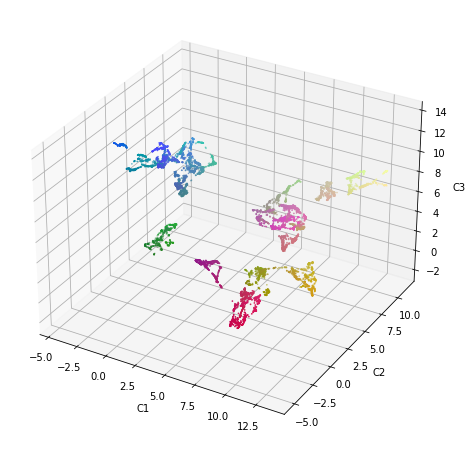

In [28]:
data_umap = draw_umap(n_neighbors=30, min_dist=0.05, n_components=3)

### Conclusion:
### PCA:
### Three principal components only explain about 60% of the variance in our data. Optimally we would get 80% or higher which we could achieve with more components but then we couldn't visualize it.
### There doesn't seem to be any specific clusters or other information in our data using PCA.
### UMAP:
### UMAP is able to pick some patterns much better. When reduced using UMAP there are obvious clusters in our data.

## Clustering

### Lets now perform the job we were meant to do - cluster our customer our data in to segments or customer groups.
### Start with KMeans clustering. Try to first find a suitable number of clusters using inertia metric (how coherent clusters are) and silhouette score (closer to 1 = tighter clusters).

C:\Users\razor\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\plotting\_matplotlib\__init__.py:61: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()


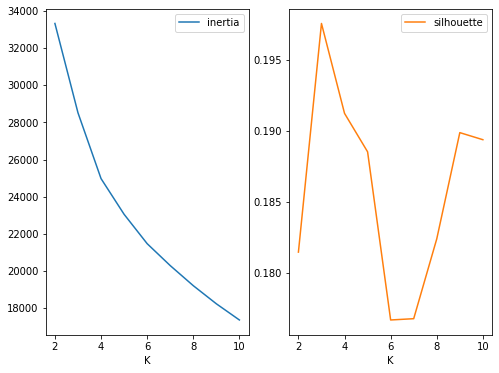

In [29]:
inertias = []
sil_scores = [] # Silhouette score
k_vals = range(2, 11)
for i in k_vals:
    km = KMeans(n_clusters=i)
    km.fit(data)
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(data, km.labels_))
fig, ax = plt.subplots(figsize=(8, 6))
_ = pd.DataFrame({"inertia" : inertias, "silhouette" : sil_scores, "K" : k_vals}).set_index("K").plot(ax=ax, subplots=True, layout=(1, 2))

### We'll select the number of clusters to be 3. Firstly, this makes sense to cluster customers to three groups, as there are 3 different spending scores. Also, the silhouette score is the best at 3 clusters.

In [30]:
km_final = KMeans(n_clusters=3)
_ = km_final.fit(data)

## Explaining Clusters

### We have clustered our data, but we must now try to explain the clusters.

### Bar plot the feature means in each cluster.

<AxesSubplot:>

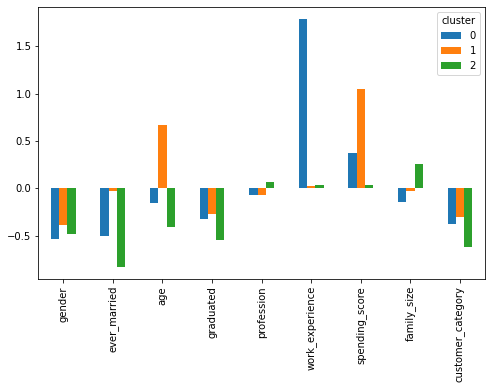

In [31]:
fig, ax = plt.subplots(figsize=(8, 5))
data.assign(cluster=km_final.labels_).groupby("cluster").mean().T.plot.bar(ax=ax)

### Lets see how the clusters in the UMAP dimensionality reduced data compares to our clusters.

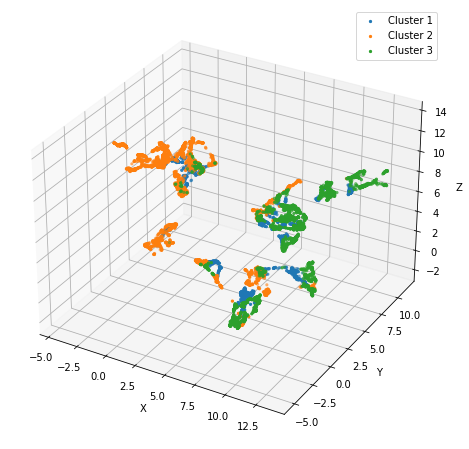

In [32]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(projection='3d')
labels_df = pd.DataFrame({"labels" : km_final.labels_})
cmap = MinMaxScaler().fit_transform(labels_df)
for i, l in enumerate(["Cluster 1", "Cluster 2", "Cluster 3"]):
    ax.scatter(data_umap[labels_df["labels"]==i].iloc[:,0], data_umap[labels_df["labels"]==i].iloc[:,1], data_umap[labels_df["labels"]==i].iloc[:,2], s=5, label=l)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()

### I would say there is some correlation with the UMAP clusters and the KMeans clusters. Most cluster 1 samples are on the positive X axis, while cluster 2 are on the negative side. With cluster 3 samples, I do not see obvious global structure, but they are clustered in small local locations.

## Clustering Conclusion

### Cluster 0 has the biggest spending customers, cluster 1 has the youngest, not yet graduated nor married customers and cluster 2 has customers with greatest work experience.
### For our final task lets insert this information to the data and save a result.

In [33]:
data_original["group"] = km_final.labels_
data_original["group"] = data_original["group"].map({0 : "Spender", 1 : "Young", 2 : "Experienced"})
data_original.head()

,gender,ever_married,age,graduated,profession,work_experience,spending_score,family_size,customer_category,group
0,1.0,0.0,22.0,0.0,5.0,1.000000,0.0,4.0,3.0,Experienced
1,0.0,1.0,38.0,1.0,2.0,5.890000,1.0,3.0,3.0,Spender
2,0.0,1.0,67.0,1.0,2.0,1.000000,0.0,1.0,5.0,Young
3,1.0,1.0,67.0,1.0,7.0,0.000000,2.0,2.0,5.0,Young
4,0.0,1.0,40.0,1.0,3.0,5.783333,2.0,6.0,5.0,Young


In [34]:
data_original.to_csv("result.csv")